# Echo State Network as a tunable frequency generator

This is a simplified implementation of Herbert Jaeger's task of learning a simple non-autonomous system, [a frequency generator controlled by an external signal](http://www.scholarpedia.org/article/Echo_state_network). Plots at the end. Please see the github page below for more information on the author of this ESN implementation.

[See the ESN implementation](https://github.com/cknd/pyESN).
<br>
<br>
Input consists of a sine wave with a base frequency. At random points in the sine wave, a square or sawtooth wave is inserted. It is inserted such that there is virtually no discontinuity. The ESN outputs a sinusoidal wave with a frequency representing the sampling rate. The short insertions of the square/sawtooth waves represent anomalies in the original signal. The goal is for the frequency of the wave outputted by the ESN to increase dramatically when it encounters an abnormality. A lookup table is used to ensure that the waveform outputted by the ESN is as continuous as possible, despite rapid changes in frequency. This step is important to avoid erratic behavior of the ESN. In short, the frequency of the wave outputted by the ESN represents the sampling rate.


In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pyESN import ESN


In [4]:
from scipy import signal
import random
import math


# find the portion of a given wave that can most easily connect to the current value of the background sine wave
def find_closest(sampling_ref, wave_ref, point, T_ref):
    """Arguments:
            sampling_ref: array of values of the sine function associated with high resolution sampling
            wave_ref: 2 periods of either square or sawtooth wave
            point: the most recent point in the sine wave to which the square/sawtooth will be connected
        Returns:
            waveform representing the sampling pattern at given spot
            waveform representing the signature component (sawtooth/square) at given point in time"""
    minDis = 1000000
    index = 0
    minIndex = 0
    period = int(len(wave_ref)/2)
    # find point within wave_ref closest to the most recent point in the background sine wave for continuity
    for index in range(period - 1):
        dis = abs(point - wave_ref[index])
        if dis < minDis:
            minDis = dis
            minIndex = index
    return (sampling_ref[minIndex:minIndex + period], wave_ref[minIndex:minIndex + period])

def generate_data(runs):
    """Arguments:
            runs: number of different sine packets with embedded signature to create: ex. runs = 2 means make 2 sine packets each with one signature
        Returns: 
            input_wave: background sine wave with sawtooth/square inserted in places
            target_wave: wave representing sampling rate, intended to be higher frequency when a signature is present"""
    freq_sine = 2 * np.pi * 2
    T  = 1/ freq_sine
    freq_signature = 2 * freq_sine
    T_sig = 1 / freq_signature
    t = np.linspace(0, 4 * T, 2000) # background time 
    sine_wave = np.sin(freq_sine * t) # background waveform  

    freq_sampling = 3 * freq_sine # default sampling rate
    freq_high_res = 4 * freq_sampling # sampling rate of important regions, intentionally a multiple of freq_signature for lineup
    sampling_wave = np.sin(freq_sampling * t)

    T_ref = np.linspace(0,2 * T_sig, 250)
    sawtooth_ref = signal.sawtooth(freq_signature * T_ref)
    #sawtooth_ref = np.concatenate((sawtooth_ref, sawtooth_ref))
    square_ref = signal.square(freq_signature * T_ref)
    #square_ref = np.concatenate((square_ref, square_ref))
    reference_waves = [square_ref, sawtooth_ref]

    high_res_wave = np.sin(freq_high_res * T_ref)


    input_wave = np.array([])
    target_wave = np.array([])

    for i in range(runs):
        wave_type = random.choice([0,1])
        insert_point = int(random.randint(0, math.floor(0.75 * 2000)))# random place to insert signature in background wave
        point = sine_wave[insert_point] # value of background wave at random time
        sampling_rate, signature = find_closest(high_res_wave, reference_waves[wave_type], point, T_ref)
        input_part1 = sine_wave[:insert_point + 1]
        input_part2 = sine_wave[insert_point + 1:]
        #final_wave = np.concatenate((final_wave, part1, signature, link(signature[-1], part2[0]), part2)) # insert signature and put wave back together
        input_wave = np.concatenate((input_wave, input_part1, signature, input_part2))
        
        target_part1 = sampling_wave[:insert_point + 1]
        target_part2 = sine_wave[insert_point + 1:]
        target_wave = np.concatenate((target_wave, target_part1, sampling_rate, target_part2))
    return (input_wave, target_wave)


In [130]:
# Use ESN to train and test
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 200,
          spectral_radius = 0.35,
          sparsity = 0.95,
          random_state=rng, silent = False)
input_training, target_training = generate_data(80)
input_testing, target_testing = generate_data(20)
pred_train = esn.fit(input_training,target_training)
output = esn.predict(input_testing)
pred_test = esn.predict(input_testing)

harvesting states...
fitting...
training error:
0.016270098365620836
test error:
3.387334639719141


Compare the frequency spectra of the output to assess how well the sampler adapts to the type of input.

Text(0.5,1,'test: model')

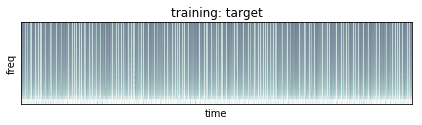

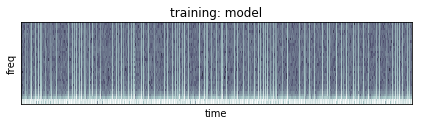

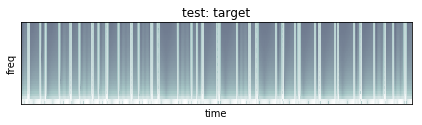

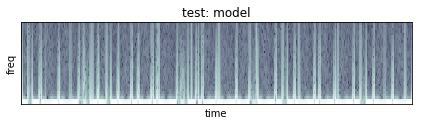

In [131]:
def draw_spectogram(data):
    plt.specgram(data,Fs=4,NFFT=256,noverlap=150,cmap=plt.cm.bone,detrend=lambda x:(x-0.5))
    plt.gca().autoscale('x')
    plt.ylim([0,0.5])
    plt.ylabel("freq")
    plt.yticks([])
    plt.xlabel("time")
    plt.xticks([])

plt.figure(figsize=(7,1.5))
draw_spectogram(target_training.flatten())
plt.title("training: target")
plt.figure(figsize=(7,1.5))
draw_spectogram(pred_train.flatten())
plt.title("training: model")

plt.figure(figsize=(7,1.5))
draw_spectogram(target_testing.flatten())
plt.title("test: target")
plt.figure(figsize=(7,1.5))
draw_spectogram(pred_test.flatten())
plt.title("test: model")